In [19]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.models import load_model


In [20]:
df = pd.read_csv("SolarRadiationDataNewDelhicsv.csv")
columns_to_drop = ['conditions','icon', 'stations','uvindex', 'severerisk','precip',
       'precipprob', 'preciptype', 'snow','temp', 'feelslike', 'snowdepth','humidity','name']
df.drop(columns=columns_to_drop, inplace=True)

df

,datetime,dew,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy
0,2023-01-01T00:00:00,10.0,10.8,5.4,250.0,1020.0,0.0,2.0,0,0.0
1,2023-01-01T01:00:00,9.0,11.2,5.4,250.0,1020.0,0.0,2.0,0,0.0
2,2023-01-01T02:00:00,7.6,11.2,0.0,307.7,1019.5,5.0,1.2,0,0.0
3,2023-01-01T03:00:00,9.0,12.2,0.0,0.0,1019.0,0.0,2.0,0,0.0
4,2023-01-01T04:00:00,9.0,9.7,5.4,270.0,1019.0,0.0,1.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
10483,2024-03-12T19:00:00,12.0,20.9,7.6,310.0,1014.0,0.0,4.0,41,0.1
10484,2024-03-12T20:00:00,13.9,20.2,5.1,232.0,1013.1,0.0,2.3,0,0.0
10485,2024-03-12T21:00:00,14.0,21.6,9.4,330.0,1015.0,0.0,4.0,0,0.0
10486,2024-03-12T22:00:00,13.0,22.7,7.6,340.0,1015.0,0.0,4.0,0,0.0


In [21]:
df.insert(0, 'Datetime', pd.Series([float('nan')] * len(df)))

In [22]:
df['Datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')
df['Datetime'].dt.strftime('%d-%m-%Y %H--00-00')
df.index = pd.to_datetime(df['Datetime'])
df = df[~((df['Datetime'].dt.hour >= 0) & (df['Datetime'].dt.hour < 7) |
                  (df['Datetime'].dt.hour >= 19) & (df['Datetime'].dt.hour < 24))]

df.drop(columns = ['datetime', 'Datetime'], inplace = True)
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)


day = 60*60*24
month = 30*day

df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Month sin'] = np.sin(df['Seconds'] * (2 * np.pi / month))
df['Month cos'] = np.cos(df['Seconds'] * (2 * np.pi / month))

df = df.drop('Seconds', axis=1)

df.head()

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_9070/4199223537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['datetime', 'Datetime'], inplace = True)
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_9070/4199223537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_9070/4199223537.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,dew,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,
2023-01-01 07:00:00,9.0,5.0,3.6,250.0,1020.0,27.2,1.0,0,0.0,0.965926,-0.258819,0.986286,-0.165048
2023-01-01 08:00:00,9.3,4.7,3.9,270.0,1021.8,37.5,1.0,1,0.0,0.866025,-0.500000,0.984808,-0.173648
2023-01-01 09:00:00,10.0,4.3,5.4,250.0,1022.0,0.0,1.0,73,0.3,0.707107,-0.707107,0.983255,-0.182236
2023-01-01 10:00:00,10.0,1.8,9.4,250.0,1023.0,0.0,2.0,209,0.8,0.500000,-0.866025,0.981627,-0.190809
2023-01-01 11:00:00,10.7,2.2,8.0,250.0,1022.5,0.0,1.9,409,1.5,0.258819,-0.965926,0.979925,-0.199368


In [23]:
data.columns

Index(['dew', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'Day sin',
       'Day cos', 'Month sin', 'Month cos'],
      dtype='object')

In [21]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][5], df_as_np[i+window_size][6]]
    y.append(label)
  return np.array(X), np.array(y)

In [22]:
X3, y3 = df_to_X_y3(df)
X3.shape, y3.shape

((4738, 7, 16), (4738, 2))

In [23]:
X3_train, y3_train = X3[:2500], y3[:2500]
X3_val, y3_val = X3[2500:3625], y3[2500:3625]
X3_test, y3_test = X3[3625:], y3[3625:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((2500, 7, 16), (2500, 2), (1125, 7, 16), (1125, 2), (1113, 7, 16), (1113, 2))

In [24]:
p_training_mean3 = np.mean(X3_train[:, :, 5])
p_training_std3 = np.std(X3_train[:, :, 5])

temp_training_mean3 = np.mean(X3_train[:, :, 6])
temp_training_std3 = np.std(X3_train[:, :, 6])

def preprocess3(X):
  X[:, :, 5] = (X[:, :, 5] - p_training_mean3) / p_training_std3
  X[:, :, 6] = (X[:, :, 6] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

In [25]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)

In [26]:
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[ 0.12674213,  1.24372364],
       [ 0.18887846,  1.27710795],
       [ 0.15004325,  1.05009462],
       ...,
       [-0.97617767, -1.20334655],
       [-1.55870574, -1.5071438 ],
       [-1.55870574, -1.5071438 ]])

In [27]:
model1 = Sequential()
model1.add(InputLayer((7, 16)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(2, 'linear'))

model1.summary()

2024-03-07 15:21:50.185764: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-07 15:21:50.185824: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-07 15:21:50.185850: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-07 15:21:50.185928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-07 15:21:50.185969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 21274 (83.10 KB)
Trainable params: 21274 (83.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [29]:
Model1 = model1.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp1])

Epoch 1/50


2024-03-07 15:21:52.261562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 1.0311 - root_mean_squared_error: 1.0154INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 12s 68ms/step - loss: 1.0311 - root_mean_squared_error: 1.0154 - val_loss: 0.9741 - val_root_mean_squared_error: 0.9870
Epoch 2/50
77/79 [============================>.] - ETA: 0s - loss: 0.9227 - root_mean_squared_error: 0.9605INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 35ms/step - loss: 0.9241 - root_mean_squared_error: 0.9613 - val_loss: 0.9643 - val_root_mean_squared_error: 0.9820
Epoch 3/50
76/79 [===========================>..] - ETA: 0s - loss: 0.8893 - root_mean_squared_error: 0.9430INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 35ms/step - loss: 0.8860 - root_mean_squared_error: 0.9413 - val_loss: 0.9114 - val_root_mean_squared_error: 0.9546
Epoch 4/50
77/79 [============================>.] - ETA: 0s - loss: 0.7976 - root_mean_squared_error: 0.8931INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.7964 - root_mean_squared_error: 0.8924 - val_loss: 0.8552 - val_root_mean_squared_error: 0.9248
Epoch 5/50
77/79 [============================>.] - ETA: 0s - loss: 0.7373 - root_mean_squared_error: 0.8586INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.7363 - root_mean_squared_error: 0.8581 - val_loss: 0.8111 - val_root_mean_squared_error: 0.9006
Epoch 6/50
77/79 [============================>.] - ETA: 0s - loss: 0.6829 - root_mean_squared_error: 0.8264INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 36ms/step - loss: 0.6845 - root_mean_squared_error: 0.8274 - val_loss: 0.7735 - val_root_mean_squared_error: 0.8795
Epoch 7/50
77/79 [============================>.] - ETA: 0s - loss: 0.6400 - root_mean_squared_error: 0.8000INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.6399 - root_mean_squared_error: 0.7999 - val_loss: 0.7388 - val_root_mean_squared_error: 0.8595
Epoch 8/50
77/79 [============================>.] - ETA: 0s - loss: 0.6073 - root_mean_squared_error: 0.7793INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.6058 - root_mean_squared_error: 0.7783 - val_loss: 0.7005 - val_root_mean_squared_error: 0.8370
Epoch 9/50
77/79 [============================>.] - ETA: 0s - loss: 0.5755 - root_mean_squared_error: 0.7586INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.5728 - root_mean_squared_error: 0.7569 - val_loss: 0.6714 - val_root_mean_squared_error: 0.8194
Epoch 10/50
77/79 [============================>.] - ETA: 0s - loss: 0.5403 - root_mean_squared_error: 0.7350INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.5395 - root_mean_squared_error: 0.7345 - val_loss: 0.6479 - val_root_mean_squared_error: 0.8049
Epoch 11/50
77/79 [============================>.] - ETA: 0s - loss: 0.5104 - root_mean_squared_error: 0.7144INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.5092 - root_mean_squared_error: 0.7136 - val_loss: 0.6167 - val_root_mean_squared_error: 0.7853
Epoch 12/50
77/79 [============================>.] - ETA: 0s - loss: 0.4831 - root_mean_squared_error: 0.6951INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.4810 - root_mean_squared_error: 0.6935 - val_loss: 0.5725 - val_root_mean_squared_error: 0.7566
Epoch 13/50
77/79 [============================>.] - ETA: 0s - loss: 0.4483 - root_mean_squared_error: 0.6696INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.4484 - root_mean_squared_error: 0.6697 - val_loss: 0.5517 - val_root_mean_squared_error: 0.7428
Epoch 14/50
77/79 [============================>.] - ETA: 0s - loss: 0.4220 - root_mean_squared_error: 0.6496INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.4211 - root_mean_squared_error: 0.6489 - val_loss: 0.5185 - val_root_mean_squared_error: 0.7201
Epoch 15/50
77/79 [============================>.] - ETA: 0s - loss: 0.3970 - root_mean_squared_error: 0.6301INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.3966 - root_mean_squared_error: 0.6298 - val_loss: 0.4903 - val_root_mean_squared_error: 0.7002
Epoch 16/50
77/79 [============================>.] - ETA: 0s - loss: 0.3766 - root_mean_squared_error: 0.6137INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.3763 - root_mean_squared_error: 0.6135 - val_loss: 0.4630 - val_root_mean_squared_error: 0.6805
Epoch 17/50
77/79 [============================>.] - ETA: 0s - loss: 0.3543 - root_mean_squared_error: 0.5952INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.3545 - root_mean_squared_error: 0.5954 - val_loss: 0.4458 - val_root_mean_squared_error: 0.6677
Epoch 18/50
77/79 [============================>.] - ETA: 0s - loss: 0.3355 - root_mean_squared_error: 0.5792INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.3340 - root_mean_squared_error: 0.5779 - val_loss: 0.4221 - val_root_mean_squared_error: 0.6497
Epoch 19/50
77/79 [============================>.] - ETA: 0s - loss: 0.3189 - root_mean_squared_error: 0.5647INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.3179 - root_mean_squared_error: 0.5638 - val_loss: 0.4043 - val_root_mean_squared_error: 0.6358
Epoch 20/50
77/79 [============================>.] - ETA: 0s - loss: 0.3004 - root_mean_squared_error: 0.5480INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 35ms/step - loss: 0.2993 - root_mean_squared_error: 0.5470 - val_loss: 0.3930 - val_root_mean_squared_error: 0.6269
Epoch 21/50
77/79 [============================>.] - ETA: 0s - loss: 0.2800 - root_mean_squared_error: 0.5292INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.2801 - root_mean_squared_error: 0.5292 - val_loss: 0.3764 - val_root_mean_squared_error: 0.6135
Epoch 22/50
77/79 [============================>.] - ETA: 0s - loss: 0.2655 - root_mean_squared_error: 0.5153INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.2646 - root_mean_squared_error: 0.5144 - val_loss: 0.3763 - val_root_mean_squared_error: 0.6134
Epoch 23/50
77/79 [============================>.] - ETA: 0s - loss: 0.2537 - root_mean_squared_error: 0.5036INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.2530 - root_mean_squared_error: 0.5030 - val_loss: 0.3628 - val_root_mean_squared_error: 0.6023
Epoch 24/50
77/79 [============================>.] - ETA: 0s - loss: 0.2433 - root_mean_squared_error: 0.4932INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.2432 - root_mean_squared_error: 0.4932 - val_loss: 0.3564 - val_root_mean_squared_error: 0.5970
Epoch 25/50
77/79 [============================>.] - ETA: 0s - loss: 0.2355 - root_mean_squared_error: 0.4853INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.2356 - root_mean_squared_error: 0.4854 - val_loss: 0.3525 - val_root_mean_squared_error: 0.5937
Epoch 26/50
77/79 [============================>.] - ETA: 0s - loss: 0.2267 - root_mean_squared_error: 0.4762INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759 - val_loss: 0.3489 - val_root_mean_squared_error: 0.5907
Epoch 27/50
77/79 [============================>.] - ETA: 0s - loss: 0.2196 - root_mean_squared_error: 0.4686INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682 - val_loss: 0.3425 - val_root_mean_squared_error: 0.5853
Epoch 28/50
77/79 [============================>.] - ETA: 0s - loss: 0.2123 - root_mean_squared_error: 0.4608INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603 - val_loss: 0.3371 - val_root_mean_squared_error: 0.5806
Epoch 29/50
79/79 [==============================] - 1s 16ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535 - val_loss: 0.3546 - val_root_mean_squared_error: 0.5955
Epoch 30/50
77/79 [============================>.] - ETA: 0s - loss: 0.1994 - root_mean_squared_error: 0.4466INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 37ms/step - loss: 0.2004 - root_mean_squared_error: 0.4476 - val_loss: 0.3354 - val_root_mean_squared_error: 0.5792
Epoch 31/50
77/79 [============================>.] - ETA: 0s - loss: 0.1953 - root_mean_squared_error: 0.4420INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411 - val_loss: 0.3314 - val_root_mean_squared_error: 0.5757
Epoch 32/50
79/79 [==============================] - 1s 15ms/step - loss: 0.1898 - root_mean_squared_error: 0.4357 - val_loss: 0.3441 - val_root_mean_squared_error: 0.5866
Epoch 33/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1862 - root_mean_squared_error: 0.4315 - val_loss: 0.3558 - val_root_mean_squared_error: 0.5965
Epoch 34/50
79/79 [==============================] - 1s 15ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271 - val_loss: 0.3372 - val_root_mean_squared_error: 0.5807
Epoch 35/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1781 - root_mean_squared_error: 0.4221 - val_loss: 0.3549 - val_root_mean_squared_error: 0.5957
Epoch 36/50
77/79 [============================>.] - ETA: 0s - loss: 0.1748 - root_mean_squared_error: 0.4181INFO:tensorflow:Assets written to: model1/a

INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180 - val_loss: 0.3287 - val_root_mean_squared_error: 0.5733
Epoch 37/50
77/79 [============================>.] - ETA: 0s - loss: 0.1699 - root_mean_squared_error: 0.4122INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.1707 - root_mean_squared_error: 0.4131 - val_loss: 0.3270 - val_root_mean_squared_error: 0.5718
Epoch 38/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1680 - root_mean_squared_error: 0.4099 - val_loss: 0.3392 - val_root_mean_squared_error: 0.5824
Epoch 39/50
77/79 [============================>.] - ETA: 0s - loss: 0.1657 - root_mean_squared_error: 0.4071INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 34ms/step - loss: 0.1653 - root_mean_squared_error: 0.4066 - val_loss: 0.3217 - val_root_mean_squared_error: 0.5672
Epoch 40/50
77/79 [============================>.] - ETA: 0s - loss: 0.1626 - root_mean_squared_error: 0.4033INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


79/79 [==============================] - 3s 35ms/step - loss: 0.1626 - root_mean_squared_error: 0.4032 - val_loss: 0.3175 - val_root_mean_squared_error: 0.5635
Epoch 41/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1602 - root_mean_squared_error: 0.4003 - val_loss: 0.3353 - val_root_mean_squared_error: 0.5791
Epoch 42/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1569 - root_mean_squared_error: 0.3962 - val_loss: 0.3365 - val_root_mean_squared_error: 0.5801
Epoch 43/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1560 - root_mean_squared_error: 0.3950 - val_loss: 0.3227 - val_root_mean_squared_error: 0.5680
Epoch 44/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1523 - root_mean_squared_error: 0.3902 - val_loss: 0.3295 - val_root_mean_squared_error: 0.5740
Epoch 45/50
79/79 [==============================] - 1s 16ms/step - loss: 0.1501 - root_mean_squared_error: 0.3875 - val_loss: 0.3287 - val_root_mean_sq

In [40]:
def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  DHI_preds, GHI_preds = predictions[:, 0], predictions[:, 1]
  DHI_actuals, GHI_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'GHI Predictions': GHI_preds,
                          'GHI Actuals':GHI_actuals,
                          'DHI Predictions': DHI_preds,
                          'DHI Actuals': DHI_actuals
                          })
  plt.plot(df['GHI Predictions'][start:end])
  plt.plot(df['GHI Actuals'][start:end])
  plt.plot(df['DHI Predictions'][start:end])
  plt.plot(df['DHI Actuals'][start:end])
  
  mse_GHI = mean_squared_error(GHI_actuals, GHI_preds)
  mse_DHI = mean_squared_error(DHI_actuals, DHI_preds)
  print("MSE for GHI Predictions:", mse_GHI)
  print("MSE for DHI Predictions:", mse_DHI)

#   nonzero_indices = np.where(GHI_actuals != 0)
#   y_true_nonzero = GHI_actuals[nonzero_indices]
#   y_pred_nonzero = GHI_preds[nonzero_indices]
    
#     # Calculate percentage error only for nonzero actual values
#   percentage_error = (y_true_nonzero - y_pred_nonzero) / y_true_nonzero

#     # Calculate MAPE and handle cases where there are no nonzero actual values
#   if len(percentage_error) > 0:
#      mape = np.mean(percentage_error) * 100
#   else:
#      mape = np.nan
#   mape = mean_absolute_percentage_error(GHI_actuals, GHI_preds)
#   print("Mean Absolute Percentage Error (MAPE):", mape)

    
  return df[start:end]



In [41]:
def pltGraph(Model):
    RootMeanSquaredError = Model.history['root_mean_squared_error']
    val_RootMeanSquaredError = Model.history['val_root_mean_squared_error']
    loss = Model.history['loss'] 
    val_loss = Model.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(50), RootMeanSquaredError, label='Training RootMeanSquaredError') 
    plt.plot(range(50), val_RootMeanSquaredError, label='Validation RootMeanSquaredError') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation RootMeanSquaredError')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.plot(range(50), loss, label='Training Loss') 
    plt.plot(range(50), val_loss, label='Validation Loss') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

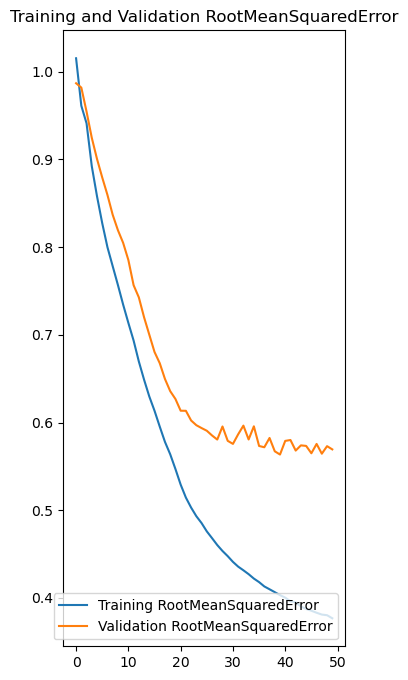

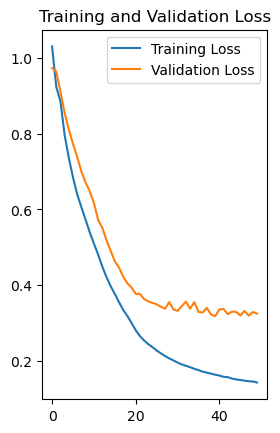

In [42]:
pltGraph(Model1)

35/35 [==============================] - 0s 4ms/step
MSE for GHI Predictions: 0.09377022197991353
MSE for DHI Predictions: 0.12066972409122328
Mean Absolute Percentage Error (MAPE): 30.888206397720534


,GHI Predictions,GHI Actuals,DHI Predictions,DHI Actuals
0,1.206405,1.243724,0.740836,0.126742
1,1.318786,1.277108,0.786858,0.188878
2,1.226619,1.050095,0.758878,0.150043
3,0.920716,0.602745,0.600789,0.103441
4,0.301812,-0.008188,0.126139,-0.129570
...,...,...,...,...
95,0.052747,-0.311985,0.395297,0.468492
96,-0.324430,-0.962979,-0.152741,-0.486854
97,-0.655342,-1.477098,-0.658491,-1.488802
98,-0.872550,-1.507144,-0.948242,-1.558706


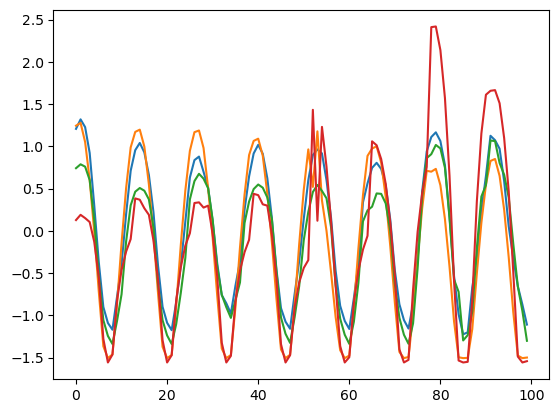

In [43]:
plot_predictions2(model1, X3_test, y3_test)

In [34]:
# Example usage:
# Assuming y_true contains the true target values and y_pred contains the predicted values


NameError: name 'Y_test' is not defined

In [57]:
input_shape = (7,16)  # Replace input_dim with your input sequence length

# Create the Sequential model
model2 = Sequential()
model2.add(InputLayer((7, 16)))
# Add the convolutional layers
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model2.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

# Add the max pooling layer
model2.add(MaxPooling1D(pool_size=2))

# Add the LSTM layer
model2.add(LSTM(units=64, return_sequences=False))

model2.add(Dense(units=8, activation='relu'))

# Add the output dense layer
model2.add(Dense(units=2, activation='linear'))  # Replace output_dim with your desired output dimensionality

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 7, 32)             1568      
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 64)             6208      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 2)                 18        
                                                      

In [58]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model2 = model2.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp2])

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 0.9930 - root_mean_squared_error: 0.9965INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 5s 46ms/step - loss: 0.9930 - root_mean_squared_error: 0.9965 - val_loss: 1.1879 - val_root_mean_squared_error: 1.0899
Epoch 2/50
77/79 [============================>.] - ETA: 0s - loss: 0.9459 - root_mean_squared_error: 0.9726INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 40ms/step - loss: 0.9452 - root_mean_squared_error: 0.9722 - val_loss: 1.0509 - val_root_mean_squared_error: 1.0251
Epoch 3/50
76/79 [===========================>..] - ETA: 0s - loss: 0.8645 - root_mean_squared_error: 0.9298INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 44ms/step - loss: 0.8665 - root_mean_squared_error: 0.9309 - val_loss: 0.9859 - val_root_mean_squared_error: 0.9929
Epoch 4/50
77/79 [============================>.] - ETA: 0s - loss: 0.7616 - root_mean_squared_error: 0.8727INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 40ms/step - loss: 0.7625 - root_mean_squared_error: 0.8732 - val_loss: 0.7621 - val_root_mean_squared_error: 0.8730
Epoch 5/50
77/79 [============================>.] - ETA: 0s - loss: 0.6542 - root_mean_squared_error: 0.8088INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.6529 - root_mean_squared_error: 0.8080 - val_loss: 0.6987 - val_root_mean_squared_error: 0.8359
Epoch 6/50
77/79 [============================>.] - ETA: 0s - loss: 0.5625 - root_mean_squared_error: 0.7500INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.5624 - root_mean_squared_error: 0.7499 - val_loss: 0.5162 - val_root_mean_squared_error: 0.7185
Epoch 7/50
77/79 [============================>.] - ETA: 0s - loss: 0.4707 - root_mean_squared_error: 0.6861INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 41ms/step - loss: 0.4698 - root_mean_squared_error: 0.6854 - val_loss: 0.4505 - val_root_mean_squared_error: 0.6712
Epoch 8/50
77/79 [============================>.] - ETA: 0s - loss: 0.4066 - root_mean_squared_error: 0.6377INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.4044 - root_mean_squared_error: 0.6359 - val_loss: 0.3900 - val_root_mean_squared_error: 0.6245
Epoch 9/50
77/79 [============================>.] - ETA: 0s - loss: 0.3465 - root_mean_squared_error: 0.5886INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.3470 - root_mean_squared_error: 0.5891 - val_loss: 0.3756 - val_root_mean_squared_error: 0.6129
Epoch 10/50
79/79 [==============================] - 1s 17ms/step - loss: 0.3072 - root_mean_squared_error: 0.5542 - val_loss: 0.3887 - val_root_mean_squared_error: 0.6234
Epoch 11/50
77/79 [============================>.] - ETA: 0s - loss: 0.2916 - root_mean_squared_error: 0.5400INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.2909 - root_mean_squared_error: 0.5393 - val_loss: 0.3283 - val_root_mean_squared_error: 0.5730
Epoch 12/50
77/79 [============================>.] - ETA: 0s - loss: 0.2574 - root_mean_squared_error: 0.5074INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 41ms/step - loss: 0.2571 - root_mean_squared_error: 0.5071 - val_loss: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 13/50
79/79 [==============================] - 1s 17ms/step - loss: 0.2431 - root_mean_squared_error: 0.4931 - val_loss: 0.4163 - val_root_mean_squared_error: 0.6452
Epoch 14/50
79/79 [==============================] - 1s 17ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717 - val_loss: 0.3031 - val_root_mean_squared_error: 0.5505
Epoch 15/50
79/79 [==============================] - 1s 17ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672 - val_loss: 0.3678 - val_root_mean_squared_error: 0.6065
Epoch 16/50
79/79 [==============================] - 1s 17ms/step - loss: 0.2042 - root_mean_squared_error: 0.4518 - val_loss: 0.3256 - val_root_mean_squared_error: 0.5706
Epoch 17/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442 - val_loss: 0.3938 - val_root_mean_sq

INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393 - val_loss: 0.2891 - val_root_mean_squared_error: 0.5377
Epoch 19/50
77/79 [============================>.] - ETA: 0s - loss: 0.1833 - root_mean_squared_error: 0.4282INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.1833 - root_mean_squared_error: 0.4281 - val_loss: 0.2870 - val_root_mean_squared_error: 0.5357
Epoch 20/50
76/79 [===========================>..] - ETA: 0s - loss: 0.1799 - root_mean_squared_error: 0.4241INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 43ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.2767 - val_root_mean_squared_error: 0.5261
Epoch 21/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1828 - root_mean_squared_error: 0.4276 - val_loss: 0.3942 - val_root_mean_squared_error: 0.6278
Epoch 22/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1727 - root_mean_squared_error: 0.4156 - val_loss: 0.3357 - val_root_mean_squared_error: 0.5794
Epoch 23/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1721 - root_mean_squared_error: 0.4148 - val_loss: 0.3016 - val_root_mean_squared_error: 0.5492
Epoch 24/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1721 - root_mean_squared_error: 0.4148 - val_loss: 0.3398 - val_root_mean_squared_error: 0.5829
Epoch 25/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1662 - root_mean_squared_error: 0.4077 - val_loss: 0.3236 - val_root_mean_sq

INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.1572 - root_mean_squared_error: 0.3965 - val_loss: 0.2691 - val_root_mean_squared_error: 0.5188
Epoch 31/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1518 - root_mean_squared_error: 0.3897 - val_loss: 0.3234 - val_root_mean_squared_error: 0.5687
Epoch 32/50
79/79 [==============================] - 1s 17ms/step - loss: 0.1549 - root_mean_squared_error: 0.3936 - val_loss: 0.2752 - val_root_mean_squared_error: 0.5246
Epoch 33/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1530 - root_mean_squared_error: 0.3912 - val_loss: 0.3129 - val_root_mean_squared_error: 0.5594
Epoch 34/50
76/79 [===========================>..] - ETA: 0s - loss: 0.1496 - root_mean_squared_error: 0.3868INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 39ms/step - loss: 0.1495 - root_mean_squared_error: 0.3867 - val_loss: 0.2652 - val_root_mean_squared_error: 0.5150
Epoch 35/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1484 - root_mean_squared_error: 0.3853 - val_loss: 0.2791 - val_root_mean_squared_error: 0.5283
Epoch 36/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1523 - root_mean_squared_error: 0.3903 - val_loss: 0.2898 - val_root_mean_squared_error: 0.5383
Epoch 37/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1496 - root_mean_squared_error: 0.3868 - val_loss: 0.2845 - val_root_mean_squared_error: 0.5334
Epoch 38/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1498 - root_mean_squared_error: 0.3870 - val_loss: 0.2776 - val_root_mean_squared_error: 0.5269
Epoch 39/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1474 - root_mean_squared_error: 0.3840 - val_loss: 0.2806 - val_root_mean_sq

INFO:tensorflow:Assets written to: model2/assets


79/79 [==============================] - 3s 38ms/step - loss: 0.1454 - root_mean_squared_error: 0.3814 - val_loss: 0.2636 - val_root_mean_squared_error: 0.5134
Epoch 42/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1444 - root_mean_squared_error: 0.3801 - val_loss: 0.3023 - val_root_mean_squared_error: 0.5498
Epoch 43/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.2998 - val_root_mean_squared_error: 0.5475
Epoch 44/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1408 - root_mean_squared_error: 0.3753 - val_loss: 0.2810 - val_root_mean_squared_error: 0.5301
Epoch 45/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1475 - root_mean_squared_error: 0.3840 - val_loss: 0.3051 - val_root_mean_squared_error: 0.5523
Epoch 46/50
79/79 [==============================] - 1s 18ms/step - loss: 0.1419 - root_mean_squared_error: 0.3767 - val_loss: 0.2797 - val_root_mean_sq

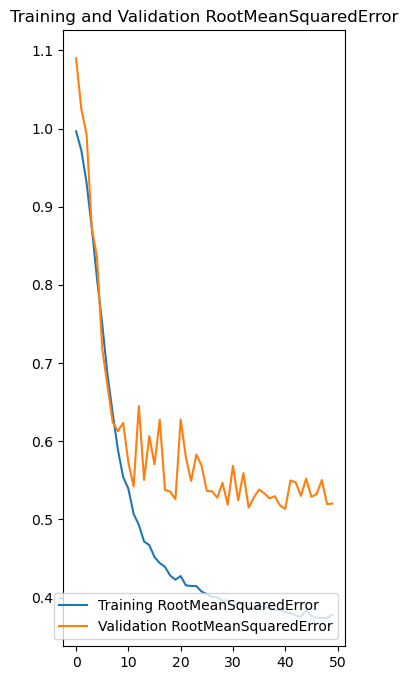

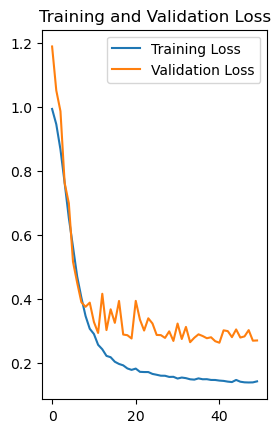

35/35 [==============================] - 1s 6ms/step
MSE for GHI Predictions: 0.0737114442437961
MSE for DHI Predictions: 0.1425489981593695


,GHI Predictions,GHI Actuals,DHI Predictions,DHI Actuals
0,1.164251,1.243724,0.867928,0.126742
1,1.119456,1.277108,0.818984,0.188878
2,1.035504,1.050095,0.824432,0.150043
3,0.593163,0.602745,0.520319,0.103441
4,0.071724,-0.008188,0.102639,-0.129570
...,...,...,...,...
95,-0.039562,-0.311985,0.294075,0.468492
96,-0.544686,-0.962979,-0.277896,-0.486854
97,-1.203264,-1.477098,-0.843805,-1.488802
98,-1.357776,-1.507144,-1.022368,-1.558706


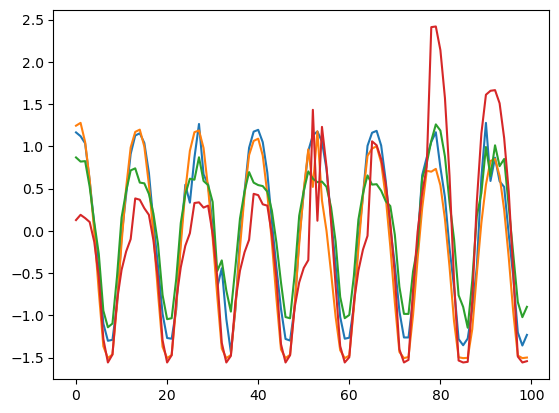

In [59]:
pltGraph(Model2)
plot_predictions2(model2, X3_test, y3_test)

In [61]:
df1 = pd.read_csv("/Users/aayushrangra/Desktop/SolarForecasting/Sheet 1-2020.csv")
df1

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45
0,2020,1,1,0,0,0,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,1,1,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,3,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,4,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2020,12,31,19,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,2020,12,31,20,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,2020,12,31,21,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8758,2020,12,31,22,0,0,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
columns_to_drop = ['Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44',
       'Unnamed: 45']
df1.drop(columns=columns_to_drop, inplace=True)

In [64]:
df1.insert(0, 'Datetime', pd.Series([float('nan')] * len(df1)))

df1 = df1[~df1['Hour'].isin(list(range(0, 6)) + list(range(19, 24)))]

# Now filtered_df contains only the rows where the hour values are between 6 and 18
df1['Datetime'] = pd.to_datetime(df1[['Year', 'Month', 'Day', 'Hour']])

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/3222183030.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Datetime'] = pd.to_datetime(df1[['Year', 'Month', 'Day', 'Hour']])


In [66]:
df1['Datetime'].dt.strftime('%d-%m-%Y %H--00-00')
df1.index = pd.to_datetime(df1['Datetime'], format='%d.%m.%Y %H:%M:%S')

In [67]:
df1

,Datetime,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,2020,1,1,6,0,0,0,0,7,...,4.6,-2.4,0,0,0,60.36,0.19,997,101,1.1
2020-01-01 07:00:00,2020-01-01 07:00:00,2020,1,1,7,0,12,27,13,7,...,5.6,-1.4,12,27,13,60.58,0.19,998,108,0.8
2020-01-01 08:00:00,2020-01-01 08:00:00,2020,1,1,8,0,112,217,164,4,...,8.3,-1.5,112,217,164,50.20,0.19,999,115,1.7
2020-01-01 09:00:00,2020-01-01 09:00:00,2020,1,1,9,0,191,369,339,1,...,11.1,-1.1,191,369,339,42.65,0.19,999,116,1.9
2020-01-01 10:00:00,2020-01-01 10:00:00,2020,1,1,10,0,237,466,482,3,...,15.3,-1.3,237,466,482,31.94,0.19,999,118,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,2020-12-31 14:00:00,2020,12,31,14,0,163,631,480,7,...,21.4,-8.5,221,237,340,12.69,0.17,992,303,1.8
2020-12-31 15:00:00,2020-12-31 15:00:00,2020,12,31,15,0,130,526,323,7,...,19.8,-7.7,155,168,217,14.94,0.17,992,303,1.2
2020-12-31 16:00:00,2020-12-31 16:00:00,2020,12,31,16,0,74,330,140,7,...,15.5,-6.8,75,79,91,20.90,0.17,992,305,1.1


In [69]:
df1.drop(columns = ['Year', 'Month', 'Day', 'Hour','Minute'], inplace = True)

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/567033288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns = ['Year', 'Month', 'Day', 'Hour','Minute'], inplace = True)


In [70]:
df1['Seconds'] = df1.index.map(pd.Timestamp.timestamp)


/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/4245636090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Seconds'] = df1.index.map(pd.Timestamp.timestamp)


In [71]:
day = 60*60*24
month = 30*day

df1['Day sin'] = np.sin(df1['Seconds'] * (2* np.pi / day))
df1['Day cos'] = np.cos(df1['Seconds'] * (2 * np.pi / day))
df1['Month sin'] = np.sin(df1['Seconds'] * (2 * np.pi / month))
df1['Month cos'] = np.cos(df1['Seconds'] * (2 * np.pi / month))
df1.head()

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/710269802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Day sin'] = np.sin(df1['Seconds'] * (2* np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/710269802.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Day cos'] = np.cos(df1['Seconds'] * (2 * np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_52354/710269802.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,...,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Seconds,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,...,60.36,0.19,997,101,1.1,1.577858e+09,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,...,60.58,0.19,998,108,0.8,1.577862e+09,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,...,50.20,0.19,999,115,1.7,1.577866e+09,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,...,42.65,0.19,999,116,1.9,1.577869e+09,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,...,31.94,0.19,999,118,2.5,1.577873e+09,0.500000,-8.660254e-01,-0.999848,-0.017452


In [72]:
df1 = df1.drop('Seconds', axis=1)
df1.head()

,Datetime,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,...,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,2020-01-01 06:00:00,0,0,0,7,0,0.338,99.43,1.0,4.6,...,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,2020-01-01 07:00:00,12,27,13,7,5,0.340,87.20,1.0,5.6,...,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,2020-01-01 08:00:00,112,217,164,4,5,0.341,76.23,1.0,8.3,...,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,2020-01-01 09:00:00,191,369,339,1,0,0.342,66.36,1.0,11.1,...,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,2020-01-01 10:00:00,237,466,482,3,5,0.343,58.38,1.0,15.3,...,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452


In [75]:
df1.drop(columns = 'Datetime', inplace = True)

In [77]:
df1.columns

Index(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Fill Flag', 'Ozone', 'Solar Zenith Angle', 'Precipitable Water',
       'Temperature', 'Dew Point', 'DHI', 'DNI', 'GHI', 'Relative Humidity',
       'Surface Albedo', 'Pressure', 'Wind Direction', 'Wind Speed', 'Day sin',
       'Day cos', 'Month sin', 'Month cos'],
      dtype='object')

In [78]:
df1.drop(columns = ['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Fill Flag'], inplace = True)

In [79]:
df1

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,7,0.338,99.43,1.0,4.6,-2.4,0,0,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,7,0.340,87.20,1.0,5.6,-1.4,12,27,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,4,0.341,76.23,1.0,8.3,-1.5,112,217,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,1,0.342,66.36,1.0,11.1,-1.1,191,369,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,3,0.343,58.38,1.0,15.3,-1.3,237,466,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7,0.263,59.94,0.4,21.4,-8.5,221,237,340,12.69,0.17,992,303,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7,0.261,68.41,0.4,19.8,-7.7,155,168,217,14.94,0.17,992,303,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7,0.259,78.60,0.4,15.5,-6.8,75,79,91,20.90,0.17,992,305,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [81]:
df1.drop(columns ='DNI', inplace = True)

In [82]:
df1

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,7,0.338,99.43,1.0,4.6,-2.4,0,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,7,0.340,87.20,1.0,5.6,-1.4,12,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,4,0.341,76.23,1.0,8.3,-1.5,112,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,1,0.342,66.36,1.0,11.1,-1.1,191,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,3,0.343,58.38,1.0,15.3,-1.3,237,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7,0.263,59.94,0.4,21.4,-8.5,221,340,12.69,0.17,992,303,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7,0.261,68.41,0.4,19.8,-7.7,155,217,14.94,0.17,992,303,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7,0.259,78.60,0.4,15.5,-6.8,75,91,20.90,0.17,992,305,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [101]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][6], df_as_np[i+window_size][7]]
    y.append(label)
  return np.array(X), np.array(y)

In [102]:
X3, y3 = df_to_X_y3(df1)
X3.shape, y3.shape


((4738, 7, 17), (4738, 2))

In [103]:
X3_train, y3_train = X3[:2500], y3[:2500]
X3_val, y3_val = X3[2500:3625], y3[2500:3625]
X3_test, y3_test = X3[3625:], y3[3625:]
X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape


((2500, 7, 17), (2500, 2), (1125, 7, 17), (1125, 2), (1113, 7, 17), (1113, 2))

In [104]:
p_training_mean3 = np.mean(X3_train[:, :, 6])
p_training_std3 = np.std(X3_train[:, :, 6])

temp_training_mean3 = np.mean(X3_train[:, :, 7])
temp_training_std3 = np.std(X3_train[:, :, 7])

def preprocess3(X):
  X[:, :, 6] = (X[:, :, 6] - p_training_mean3) / p_training_std3
  X[:, :, 7] = (X[:, :, 7] - temp_training_mean3) / temp_training_std3

def preprocess_output3(y):
  y[:, 0] = (y[:, 0] - p_training_mean3) / p_training_std3
  y[:, 1] = (y[:, 1] - temp_training_mean3) / temp_training_std3
  return y

In [105]:
preprocess3(X3_train)
preprocess3(X3_val)
preprocess3(X3_test)
preprocess_output3(y3_train)
preprocess_output3(y3_val)
preprocess_output3(y3_test)

array([[ 0.12674213,  1.24372364],
       [ 0.18887846,  1.27710795],
       [ 0.15004325,  1.05009462],
       ...,
       [-0.97617767, -1.20334655],
       [-1.55870574, -1.5071438 ],
       [-1.55870574, -1.5071438 ]])

In [106]:
df1

,Cloud Type,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Day sin,Day cos,Month sin,Month cos
Datetime,,,,,,,,,,,,,,,,,
2020-01-01 06:00:00,7,0.338,99.43,1.0,4.6,-2.4,0,0,60.36,0.19,997,101,1.1,1.000000,1.023369e-11,-0.998630,-0.052336
2020-01-01 07:00:00,7,0.340,87.20,1.0,5.6,-1.4,12,13,60.58,0.19,998,108,0.8,0.965926,-2.588190e-01,-0.999048,-0.043619
2020-01-01 08:00:00,4,0.341,76.23,1.0,8.3,-1.5,112,164,50.20,0.19,999,115,1.7,0.866025,-5.000000e-01,-0.999391,-0.034899
2020-01-01 09:00:00,1,0.342,66.36,1.0,11.1,-1.1,191,339,42.65,0.19,999,116,1.9,0.707107,-7.071068e-01,-0.999657,-0.026177
2020-01-01 10:00:00,3,0.343,58.38,1.0,15.3,-1.3,237,482,31.94,0.19,999,118,2.5,0.500000,-8.660254e-01,-0.999848,-0.017452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:00:00,7,0.263,59.94,0.4,21.4,-8.5,221,340,12.69,0.17,992,303,1.8,-0.500000,-8.660254e-01,-0.484810,0.874620
2020-12-31 15:00:00,7,0.261,68.41,0.4,19.8,-7.7,155,217,14.94,0.17,992,303,1.2,-0.707107,-7.071068e-01,-0.477159,0.878817
2020-12-31 16:00:00,7,0.259,78.60,0.4,15.5,-6.8,75,91,20.90,0.17,992,305,1.1,-0.866025,-5.000000e-01,-0.469472,0.882948


In [107]:
from tensorflow.keras.layers import Conv1D, LSTM

# Define input shape
input_shape = (7, 17)  # Replace input_dim with your input sequence length

model3 = Sequential()

# Add 1D CNN layers
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model3.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model3.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))

# Add LSTM layers
model3.add(LSTM(units=64, return_sequences=True))
model3.add(LSTM(units=64, return_sequences=True))
model3.add(LSTM(units=64, return_sequences=False))

# Add Dense layers
model3.add(Dense(units=8, activation='relu'))
model3.add(Dense(units=2, activation='linear'))

model3.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 7, 32)             1664      
                                                                 
 conv1d_10 (Conv1D)          (None, 7, 64)             6208      
                                                                 
 conv1d_11 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 lstm_10 (LSTM)              (None, 7, 64)             49408     
                                                                 
 lstm_11 (LSTM)              (None, 7, 64)             33024     
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 8)                

In [108]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model3 = model3.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=50, callbacks=[cp3])

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 0.9854 - root_mean_squared_error: 0.9927INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 13s 111ms/step - loss: 0.9854 - root_mean_squared_error: 0.9927 - val_loss: 1.0069 - val_root_mean_squared_error: 1.0035
Epoch 2/50
79/79 [==============================] - ETA: 0s - loss: 0.9071 - root_mean_squared_error: 0.9524INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 93ms/step - loss: 0.9071 - root_mean_squared_error: 0.9524 - val_loss: 0.7984 - val_root_mean_squared_error: 0.8936
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 0.7359 - root_mean_squared_error: 0.8579INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 90ms/step - loss: 0.7359 - root_mean_squared_error: 0.8579 - val_loss: 0.7185 - val_root_mean_squared_error: 0.8476
Epoch 4/50
79/79 [==============================] - ETA: 0s - loss: 0.5428 - root_mean_squared_error: 0.7368INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 8s 97ms/step - loss: 0.5428 - root_mean_squared_error: 0.7368 - val_loss: 0.6588 - val_root_mean_squared_error: 0.8116
Epoch 5/50
79/79 [==============================] - ETA: 0s - loss: 0.4168 - root_mean_squared_error: 0.6456INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 88ms/step - loss: 0.4168 - root_mean_squared_error: 0.6456 - val_loss: 0.4416 - val_root_mean_squared_error: 0.6645
Epoch 6/50
79/79 [==============================] - ETA: 0s - loss: 0.3194 - root_mean_squared_error: 0.5652INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 8s 97ms/step - loss: 0.3194 - root_mean_squared_error: 0.5652 - val_loss: 0.3828 - val_root_mean_squared_error: 0.6187
Epoch 7/50
79/79 [==============================] - ETA: 0s - loss: 0.2801 - root_mean_squared_error: 0.5292INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 91ms/step - loss: 0.2801 - root_mean_squared_error: 0.5292 - val_loss: 0.3307 - val_root_mean_squared_error: 0.5751
Epoch 8/50
79/79 [==============================] - 3s 33ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993 - val_loss: 0.4257 - val_root_mean_squared_error: 0.6525
Epoch 9/50
79/79 [==============================] - 3s 33ms/step - loss: 0.2243 - root_mean_squared_error: 0.4736 - val_loss: 0.4213 - val_root_mean_squared_error: 0.6491
Epoch 10/50
79/79 [==============================] - ETA: 0s - loss: 0.2000 - root_mean_squared_error: 0.4472INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 94ms/step - loss: 0.2000 - root_mean_squared_error: 0.4472 - val_loss: 0.2749 - val_root_mean_squared_error: 0.5243
Epoch 11/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1894 - root_mean_squared_error: 0.4352 - val_loss: 0.2988 - val_root_mean_squared_error: 0.5466
Epoch 12/50
79/79 [==============================] - ETA: 0s - loss: 0.1747 - root_mean_squared_error: 0.4180INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 88ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180 - val_loss: 0.2626 - val_root_mean_squared_error: 0.5125
Epoch 13/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1783 - root_mean_squared_error: 0.4223 - val_loss: 0.2654 - val_root_mean_squared_error: 0.5152
Epoch 14/50
79/79 [==============================] - ETA: 0s - loss: 0.1694 - root_mean_squared_error: 0.4116INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 94ms/step - loss: 0.1694 - root_mean_squared_error: 0.4116 - val_loss: 0.2459 - val_root_mean_squared_error: 0.4959
Epoch 15/50
79/79 [==============================] - ETA: 0s - loss: 0.1658 - root_mean_squared_error: 0.4072INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 89ms/step - loss: 0.1658 - root_mean_squared_error: 0.4072 - val_loss: 0.2446 - val_root_mean_squared_error: 0.4945
Epoch 16/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1539 - root_mean_squared_error: 0.3923 - val_loss: 0.2985 - val_root_mean_squared_error: 0.5464
Epoch 17/50
78/79 [============================>.] - ETA: 0s - loss: 0.1708 - root_mean_squared_error: 0.4133INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 8s 99ms/step - loss: 0.1711 - root_mean_squared_error: 0.4137 - val_loss: 0.2296 - val_root_mean_squared_error: 0.4791
Epoch 18/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1536 - root_mean_squared_error: 0.3919 - val_loss: 0.2456 - val_root_mean_squared_error: 0.4956
Epoch 19/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1448 - root_mean_squared_error: 0.3806 - val_loss: 0.2311 - val_root_mean_squared_error: 0.4808
Epoch 20/50
79/79 [==============================] - ETA: 0s - loss: 0.1578 - root_mean_squared_error: 0.3973INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 7s 86ms/step - loss: 0.1578 - root_mean_squared_error: 0.3973 - val_loss: 0.2100 - val_root_mean_squared_error: 0.4582
Epoch 21/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1424 - root_mean_squared_error: 0.3773 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5004
Epoch 22/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1452 - root_mean_squared_error: 0.3811 - val_loss: 0.3578 - val_root_mean_squared_error: 0.5982
Epoch 23/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1464 - root_mean_squared_error: 0.3826 - val_loss: 0.2586 - val_root_mean_squared_error: 0.5086
Epoch 24/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1399 - root_mean_squared_error: 0.3740 - val_loss: 0.2160 - val_root_mean_squared_error: 0.4648
Epoch 25/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.3036 - val_root_mean_sq

INFO:tensorflow:Assets written to: model3/assets


79/79 [==============================] - 8s 96ms/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.2073 - val_root_mean_squared_error: 0.4553
Epoch 42/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1155 - root_mean_squared_error: 0.3398 - val_loss: 0.2583 - val_root_mean_squared_error: 0.5082
Epoch 43/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1171 - root_mean_squared_error: 0.3421 - val_loss: 0.2140 - val_root_mean_squared_error: 0.4626
Epoch 44/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1252 - root_mean_squared_error: 0.3539 - val_loss: 0.2764 - val_root_mean_squared_error: 0.5257
Epoch 45/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1175 - root_mean_squared_error: 0.3427 - val_loss: 0.2260 - val_root_mean_squared_error: 0.4754
Epoch 46/50
79/79 [==============================] - 3s 33ms/step - loss: 0.1185 - root_mean_squared_error: 0.3443 - val_loss: 0.2266 - val_root_mean_sq

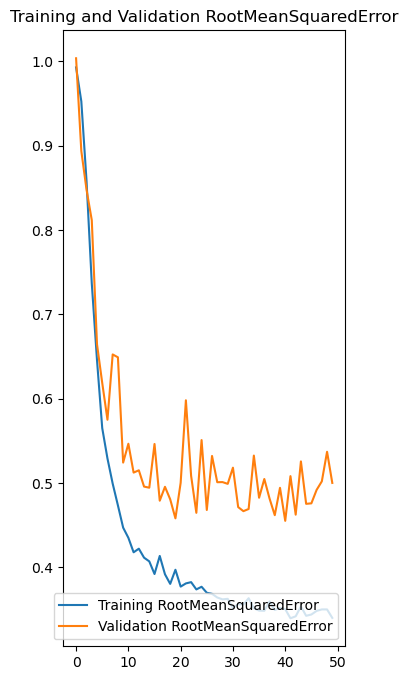

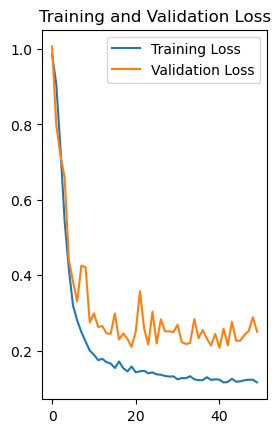

In [109]:
pltGraph(Model3)